**Ben KABONGO**, *21116436*, M1 DAC

# NLP & representation learning: Neural Embeddings, Text Classification


To use statistical classifiers with text, it is first necessary to vectorize the text. In the first practical session we explored the **Bag of Word (BoW)** model. 

Modern **state of the art** methods uses  embeddings to vectorize the text before classification in order to avoid feature engineering.

## [Dataset](https://thome.isir.upmc.fr/classes/RITAL/json_pol)


## "Modern" NLP pipeline

By opposition to the **bag of word** model, in the modern NLP pipeline everything is **embeddings**. Instead of encoding a text as a **sparse vector** of length $D$ (size of feature dictionnary) the goal is to encode the text in a meaningful dense vector of a small size $|e| <<< |D|$. 


The raw classification pipeline is then the following:

```
raw text ---|embedding table|-->  vectors --|Neural Net|--> class 
```


### Using a  language model:

How to tokenize the text and extract a feature dictionnary is still a manual task. To directly have meaningful embeddings, it is common to use a pre-trained language model such as `word2vec` which we explore in this practical.

In this setting, the pipeline becomes the following:
```
      
raw text ---|(pre-trained) Language Model|--> vectors --|classifier (or fine-tuning)|--> class 
```


- #### Classic word embeddings

 - [Word2Vec](https://arxiv.org/abs/1301.3781)
 - [Glove](https://nlp.stanford.edu/projects/glove/)


- #### bleeding edge language models techniques (see next)

 - [UMLFIT](https://arxiv.org/abs/1801.06146)
 - [ELMO](https://arxiv.org/abs/1802.05365)
 - [GPT](https://blog.openai.com/language-unsupervised/)
 - [BERT](https://arxiv.org/abs/1810.04805)






### Goal of this session:

1. Train word embeddings on training dataset
2. Tinker with the learnt embeddings and see learnt relations
3. Tinker with pre-trained embeddings.
4. Use those embeddings for classification
5. Compare different embedding models
6. Pytorch first look: learn to generate text.

## STEP 0: Loading data 

In [1]:
import json
from collections import Counter

# Loading json
with open("ressources/json_pol",encoding="utf-8") as f:
    data = f.readlines()
    json_data = json.loads(data[0])
    train = json_data["train"]
    test = json_data["test"]
    

# Quick Check
counter_train = Counter((x[1] for x in train))
counter_test = Counter((x[1] for x in test))
print("Number of train reviews : ", len(train))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train[0])
print("")
print("Number of test reviews : ",len(test))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test[0])
print("")

Number of train reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

["The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it.", 1]

Number of test reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old 

In [2]:
import string
import re

def preprocess(text):
    text = re.sub('[0-9]+', '', text)
    punc = string.punctuation 
    punc += '\n\r\t'
    return text.translate(str.maketrans(punc, ' ' * len(punc)))

In [3]:
import pandas as pd
train_df = pd.DataFrame(train, columns=['text', 'label'])
train_df

,text,label
0,The undoubted highlight of this movie is Peter...,1
1,More eeriness and dark secrets released in the...,1
2,This was one of those films I probably never w...,1
3,i love this film. the songs and story lines ar...,1
4,I really truly enjoyed this movie. (Which is w...,1
...,...,...
24995,"""Arahan"" adds nothing positive to the Kung Fu ...",0
24996,"I'm not sure quite why I clicked ""contains spo...",0
24997,"In fact, Marc Blitzstein's off-Broadway adapta...",0
24998,(Spoilers galore) This is an absolutely awful ...,0


In [4]:
test_df = pd.DataFrame(test, columns=['text', 'label'])
test_df

,text,label
0,Although credit should have been given to Dr. ...,1
1,This was one of those films I would always com...,1
2,The Man Who Knew Too Much{1956}is a remake of ...,1
3,Jamie Foxx does a fine job of impersonating th...,1
4,12/17/01 All I can do with this film is improv...,1
...,...,...
24995,"I wasn't impressed with the Graffiti Artist, d...",0
24996,Here is a rundown of a typical Rachael Ray Sho...,0
24997,Wow...not in a good way.<br /><br />I can't be...,0
24998,This movie made me want to bang my head agains...,0


## Word2Vec: Quick Recap

**[Word2Vec](https://arxiv.org/abs/1301.3781) is composed of two distinct language models (CBOW and SG), optimized to quickly learn word vectors**


given a random text: `i'm taking the dog out for a walk`



### (a) Continuous Bag of Word (CBOW)
    -  predicts a word given a context
    
maximizing `p(dog | i'm taking the ___ out for a walk)`
    
### (b) Skip-Gram (SG)               
    -  predicts a context given a word
    
 maximizing `p(i'm taking the out for a walk | dog)`



   

## STEP 1: train a language model (word2vec)

Gensim has one of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) fastest implementation.


### Train:

In [5]:
# if gensim not installed yet
# ! pip install gensim

In [6]:
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#text = [t.split() for t,p in train]
text = [t.split() for t in train_df.text.map(preprocess)]

# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1, epochs=5)

2023-02-16 00:09:38,413 : INFO : collecting all words and their counts
2023-02-16 00:09:38,414 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-02-16 00:09:38,707 : INFO : PROGRESS: at sentence #10000, processed 2426102 words, keeping 61702 word types
2023-02-16 00:09:39,011 : INFO : PROGRESS: at sentence #20000, processed 4816878 words, keeping 84298 word types
2023-02-16 00:09:39,153 : INFO : collected 93201 word types from a corpus of 6022875 raw words and 25000 sentences
2023-02-16 00:09:39,154 : INFO : Creating a fresh vocabulary
2023-02-16 00:09:39,239 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 33359 unique words (35.79253441486679%% of original 93201, drops 59842)', 'datetime': '2023-02-16T00:09:39.239185', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2023-02-16 00:09:39,239 : INFO : Word2Vec lifecycle event

2023-02-16 00:10:20,330 : INFO : EPOCH 4 - PROGRESS: at 98.31% examples, 434413 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:10:20,439 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-02-16 00:10:20,480 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-02-16 00:10:20,485 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-02-16 00:10:20,485 : INFO : EPOCH - 4 : training on 6022875 raw words (4500473 effective words) took 10.3s, 434961 effective words/s
2023-02-16 00:10:21,509 : INFO : EPOCH 5 - PROGRESS: at 9.78% examples, 438046 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:10:22,528 : INFO : EPOCH 5 - PROGRESS: at 20.02% examples, 445311 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:10:23,539 : INFO : EPOCH 5 - PROGRESS: at 30.06% examples, 446264 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:10:24,566 : INFO : EPOCH 5 - PROGRESS: at 40.23% examples, 446252 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:10:25,568 :

In [7]:
# Worth it to save the previous embedding
w2v.save("W2v-movies.dat")
# You will be able to reload them:
# w2v = gensim.models.Word2Vec.load("W2v-movies.dat")
# and you can continue the learning process if needed

2023-02-16 00:10:30,523 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'W2v-movies.dat', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-02-16T00:10:30.523785', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'saving'}
2023-02-16 00:10:30,524 : INFO : not storing attribute cum_table
2023-02-16 00:10:30,546 : INFO : saved W2v-movies.dat


## STEP 2: Test learnt embeddings

The word embedding space directly encodes similarities between words: the vector coding for the word "great" will be closer to the vector coding for "good" than to the one coding for "bad". Generally, [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is the distance used when considering distance between vectors.

KeyedVectors have a built in [similarity](https://radimrehurek.com/gensim/models /keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.similarity) method to compute the cosine similarity between words

In [8]:
# is great really closer to good than to bad ?
print("great and good:",w2v.wv.similarity("great","good"))
print("great and bad:",w2v.wv.similarity("great","bad"))

great and good: 0.76782584
great and bad: 0.5397215


Since cosine distance encodes similarity, neighboring words are supposed to be similar. The [most_similar](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.most_similar) method returns the `topn` words given a query.

In [9]:
# The query can be as simple as a word, such as "movie"

# Try changing the word
for word in ['movie', 'awesome', 'actor']:
    print(word, ':')
    for item in w2v.wv.most_similar(word,topn=5):
        print('\t', item)

movie :
	 ('film', 0.9328461289405823)
	 ('programme', 0.7791712284088135)
	 ('flick', 0.7638271450996399)
	 ('monstrosity', 0.7471099495887756)
	 ('it', 0.7395325899124146)
awesome :
	 ('amazing', 0.7928280830383301)
	 ('incredible', 0.7682960629463196)
	 ('fantastic', 0.7515002489089966)
	 ('cool', 0.7180612683296204)
	 ('excellent', 0.7168706059455872)
actor :
	 ('musician', 0.736379861831665)
	 ('actress', 0.7326823472976685)
	 ('comedian', 0.7259320616722107)
	 ('impersonation', 0.7138898968696594)
	 ('songwriter', 0.689059853553772)


But it can be a more complicated query
Word embedding spaces tend to encode much more.

The most famous exemple is: `vec(king) - vec(man) + vec(woman) => vec(queen)`

In [10]:
# What is awesome - good + bad ?
positives = [
    ["awesome","bad"],
    ["actor","woman"]
]

negatives = [
    ["good"],
    ["man"]
]

for i in range(2):
    print(*positives[i], '--', *negatives[i])
    for item in w2v.wv.most_similar(positive=positives[i],negative=negatives[i],topn=5):
        print('\t', item)

awesome bad -- good
	 ('awful', 0.7341099977493286)
	 ('Terrible', 0.6573300361633301)
	 ('terrible', 0.6454448103904724)
	 ('atrocious', 0.6421670913696289)
	 ('horrible', 0.6358762979507446)
actor woman -- man
	 ('actress', 0.8530353307723999)
	 ('comedienne', 0.6491321325302124)
	 ('dancer', 0.6273465156555176)
	 ('performer', 0.6254771947860718)
	 ('gentleman', 0.6113918423652649)


In [11]:
        
#w2v.wv.most_similar(positive=["awesome","bad"],negative=["good"],topn=3)  

#w2v.wv.most_similar(positive=["actor","woman"],negative=["man"],topn=3) # do the famous exemple works for actor ?


# Try other things like plurals for exemple.
positives = [
    ["movie","movies"],
    ["actor","actors"]
]

negatives = [
    ["film"],
    ["actress"]
]

for i in range(2):
    print(*positives[i], '--', *negatives[i])
    for item in w2v.wv.most_similar(positive=positives[i],negative=negatives[i],topn=5):
        print('\t', item)

movie movies -- film
	 ('flicks', 0.7785832285881042)
	 ('films', 0.7654721140861511)
	 ('cartoons', 0.7107298374176025)
	 ('slashers', 0.6972025632858276)
	 ('comedies', 0.6872580051422119)
actor actors -- actress
	 ('Spacey', 0.6671654582023621)
	 ('professionals', 0.634136974811554)
	 ('scriptwriters', 0.6328943967819214)
	 ('amateurs', 0.6313664317131042)
	 ('directors', 0.6313294768333435)


To test learnt "synctactic" and "semantic" similarities, Mikolov et al. introduced a special dataset containing a wide variety of three way similarities.

In [12]:
#out = w2v.wv.evaluate_word_analogies("ressources/questions-words.txt",case_insensitive=True)  #original semantic syntactic dataset.

**When training the w2v models on the review dataset, since it hasn't been learnt with a lot of data, it does not perform very well.**


## STEP 3: Loading a pre-trained model

In Gensim, embeddings are loaded and can be used via the ["KeyedVectors"](https://radimrehurek.com/gensim/models/keyedvectors.html) class

> Since trained word vectors are independent from the way they were trained (Word2Vec, FastText, WordRank, VarEmbed etc), they can be represented by a standalone structure, as implemented in this module.

>The structure is called “KeyedVectors” and is essentially a mapping between entities and vectors. Each entity is identified by its string id, so this is a mapping between {str => 1D numpy array}.

>The entity typically corresponds to a word (so the mapping maps words to 1D vectors), but for some models, they key can also correspond to a document, a graph node etc. To generalize over different use-cases, this module calls the keys entities. Each entity is always represented by its string id, no matter whether the entity is a word, a document or a graph node.

In [13]:
#from gensim.test.utils import get_tmpfile
import gensim.downloader as api
bload = True
fname = "word2vec-google-news-300"
sdir = "" # Change

if(bload==True):
    wv_pre_trained = gensim.models.KeyedVectors.load(sdir+fname+".dat")
else:    
    wv_pre_trained = api.load(fname)
    wv_pre_trained.save(sdir+fname+".dat")
    

2023-02-16 00:10:30,590 : INFO : loading KeyedVectors object from word2vec-google-news-300.dat
2023-02-16 00:10:31,509 : INFO : loading vectors from word2vec-google-news-300.dat.vectors.npy with mmap=None
2023-02-16 00:10:33,297 : INFO : KeyedVectors lifecycle event {'fname': 'word2vec-google-news-300.dat', 'datetime': '2023-02-16T00:10:33.282893', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


**Perform the "synctactic" and "semantic" evaluations again. Conclude on the pre-trained embeddings.**

In [14]:
print("great and good:",wv_pre_trained.similarity("great","good"))
print("great and bad:",wv_pre_trained.similarity("great","bad"))

great and good: 0.72915095
great and bad: 0.3928765


In [15]:
for word in ['movie', 'awesome', 'actor']:
    print(word, ':')
    for item in wv_pre_trained.most_similar(word,topn=5):
        print('\t', item)

movie :
	 ('film', 0.8676770329475403)
	 ('movies', 0.8013108372688293)
	 ('films', 0.7363012433052063)
	 ('moive', 0.6830361485481262)
	 ('Movie', 0.6693679094314575)
awesome :
	 ('amazing', 0.8282864689826965)
	 ('unbelievable', 0.7464959025382996)
	 ('fantastic', 0.7453292012214661)
	 ('incredible', 0.7390913963317871)
	 ('unbelieveable', 0.6678116917610168)
actor :
	 ('actress', 0.7930010557174683)
	 ('Actor', 0.7446157932281494)
	 ('thesp', 0.6954971551895142)
	 ('thespian', 0.6651668548583984)
	 ('actors', 0.6519852876663208)


In [16]:
positives = [
    ["awesome","bad"],
    ["actor","woman"]
]

negatives = [
    ["good"],
    ["man"]
]

for i in range(2):
    print(*positives[i], '--', *negatives[i])
    for item in wv_pre_trained.most_similar(positive=positives[i],negative=negatives[i],topn=5):
        print('\t', item)

awesome bad -- good
	 ('horrible', 0.5953484773635864)
	 ('amazing', 0.5928210020065308)
	 ('weird', 0.5782380700111389)
	 ('freaky', 0.5767403244972229)
	 ('unbelievable', 0.5747914910316467)
actor woman -- man
	 ('actress', 0.8602624535560608)
	 ('actresses', 0.6596671342849731)
	 ('thesp', 0.6290916800498962)
	 ('Actress', 0.6165293455123901)
	 ('actress_Rachel_Weisz', 0.5997323393821716)


In [17]:
positives = [
    ["movie","movies"],
    ["actor","actors"]
]

negatives = [
    ["film"],
    ["actress"]
]

for i in range(2):
    print(*positives[i], '--', *negatives[i])
    for item in wv_pre_trained.most_similar(positive=positives[i],negative=negatives[i],topn=5):
        print('\t', item)

movie movies -- film
	 ('films', 0.6389263868331909)
	 ('Movies', 0.6188486814498901)
	 ('flicks', 0.6120561361312866)
	 ('Hollywood_blockbusters', 0.5958892703056335)
	 ('romcoms', 0.5864962339401245)
actor actors -- actress
	 ('Actors', 0.6128960251808167)
	 ('thesps', 0.5747196674346924)
	 ('screenwriters', 0.5588046908378601)
	 ('thespians', 0.5531652569770813)
	 ('thespian', 0.5476460456848145)


## STEP 4:  sentiment classification

In the previous practical session, we used a bag of word approach to transform text into vectors.
Here, we propose to try to use word vectors (previously learnt or loaded).


### <font color='green'> Since we have only word vectors and that sentences are made of multiple words, we need to aggregate them. </font>


### (1) Vectorize reviews using word vectors:

Word aggregation can be done in different ways:

- Sum
- Average
- Min/feature
- Max/feature

#### a few pointers:

- `w2v.wv.vocab` is a `set()` of the vocabulary (all existing words in your model)
- `np.minimum(a,b) and np.maximum(a,b)` respectively return element-wise min/max 

In [18]:
import numpy as np
# We first need to vectorize text:
# First we propose to a sum of them


def vectorize(text, f=np.sum, model=wv_pre_trained):
    """
    This function should vectorize one review

    input: str, numpy agregate function
    output: np.array(float)
    """    
    vec = []
    for word in preprocess(text):
        if word in model.key_to_index:
            vec.append(model[word])
    return f(vec, axis=0)
    

In [19]:
vectorize(train_df.text[0])

array([-6.8882080e+01,  5.0358612e+01, -4.2053223e-02,  5.2835480e+01,
       -2.5050629e+01,  1.0630341e+01, -3.9978210e+01, -2.2337036e+01,
       -1.9577698e+01,  1.1810776e+01, -1.8968021e+01, -3.8820648e+01,
       -8.7164398e+01,  1.1624546e+01, -5.5066895e+01,  3.9756592e+01,
        4.4158363e+01,  7.1197632e+01, -4.0677338e+00,  1.3945007e-01,
       -1.0449817e+02, -1.5634384e+01,  4.9755814e+01,  8.5149994e+00,
       -3.4336380e+01,  1.0841086e+01, -1.0523462e+02,  2.0532532e+01,
       -1.1974487e+01, -8.8734436e+00, -3.5450745e+00,  1.3266159e+01,
       -2.8181610e+01, -4.5545288e+01, -5.4851898e+01,  3.7212555e+01,
       -8.4447968e+01,  5.0229980e+01, -2.4678310e+01,  3.7364990e+01,
       -1.5668884e+01, -1.7890625e+01,  2.4233398e+01,  3.5927063e+01,
        2.1099434e+01, -1.5949348e+01, -1.3954895e+01, -7.5196045e+01,
       -5.0344238e+01,  3.2897095e+01, -7.5712280e+01,  1.0140381e+02,
       -1.0659912e+01,  9.3589050e+01,  1.5606079e+01,  5.3395996e+01,
      

In [20]:
#X = [vectorize(text) for text,pol in train]
X = list(train_df.text.map(vectorize))
y = np.array(train_df.label)

#X_test = [vectorize(text) for text,pol in test]
X_test = list(test_df.text.map(vectorize))
y_test = np.array(test_df.label)

#let's see what a review vector looks like.
print(X[0])

[-6.8882080e+01  5.0358612e+01 -4.2053223e-02  5.2835480e+01
 -2.5050629e+01  1.0630341e+01 -3.9978210e+01 -2.2337036e+01
 -1.9577698e+01  1.1810776e+01 -1.8968021e+01 -3.8820648e+01
 -8.7164398e+01  1.1624546e+01 -5.5066895e+01  3.9756592e+01
  4.4158363e+01  7.1197632e+01 -4.0677338e+00  1.3945007e-01
 -1.0449817e+02 -1.5634384e+01  4.9755814e+01  8.5149994e+00
 -3.4336380e+01  1.0841086e+01 -1.0523462e+02  2.0532532e+01
 -1.1974487e+01 -8.8734436e+00 -3.5450745e+00  1.3266159e+01
 -2.8181610e+01 -4.5545288e+01 -5.4851898e+01  3.7212555e+01
 -8.4447968e+01  5.0229980e+01 -2.4678310e+01  3.7364990e+01
 -1.5668884e+01 -1.7890625e+01  2.4233398e+01  3.5927063e+01
  2.1099434e+01 -1.5949348e+01 -1.3954895e+01 -7.5196045e+01
 -5.0344238e+01  3.2897095e+01 -7.5712280e+01  1.0140381e+02
 -1.0659912e+01  9.3589050e+01  1.5606079e+01  5.3395996e+01
 -6.4790283e+01 -3.9895462e+01  5.2529144e-01 -6.5427002e+01
 -5.7098602e+01 -3.1768066e+01 -7.9039368e+01 -2.2490005e+01
 -1.5918243e+01 -8.04138

### (2) Train a classifier 
as in the previous practical session, train a logistic regression to do sentiment classification with word vectors



In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scikit Logistic Regression
lr = LogisticRegression()
lr.fit(X, y)

y_pred = lr.predict(X_test)

print('Accuracy :', accuracy_score(y_pred, y_test))

Accuracy : 0.62832


/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
def vectorize_train_test(f, m=wv_pre_trained):
    l = lambda x: vectorize(x, f, m)
    
    #X = [vectorize(text) for text,pol in train]
    X = list(train_df.text.map(l))
    y = np.array(train_df.label)

    #X_test = [vectorize(text) for text,pol in test]
    X_test = list(test_df.text.map(l))
    y_test = np.array(test_df.label)
    
    lr = LogisticRegression()
    lr.fit(X, y)

    y_pred = lr.predict(X_test)

    return accuracy_score(y_pred, y_test)

In [23]:
vectorize_train_test(np.mean)

0.6118

In [24]:
vectorize_train_test(np.min)

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5644

performance should be worst than with bag of word (~80%). Sum/Mean aggregation does not work well on long reviews (especially with many frequent words). This adds a lot of noise.

## **Todo** :  Try answering the following questions:

- Which word2vec model works best: skip-gram or cbow
- Do pretrained vectors work best than those learnt on the train dataset ?


In [25]:
w2v_sg = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1, epochs=5)

2023-02-16 00:14:22,383 : INFO : collecting all words and their counts
2023-02-16 00:14:22,385 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-02-16 00:14:22,895 : INFO : PROGRESS: at sentence #10000, processed 2426102 words, keeping 61702 word types
2023-02-16 00:14:23,464 : INFO : PROGRESS: at sentence #20000, processed 4816878 words, keeping 84298 word types
2023-02-16 00:14:23,721 : INFO : collected 93201 word types from a corpus of 6022875 raw words and 25000 sentences
2023-02-16 00:14:23,722 : INFO : Creating a fresh vocabulary
2023-02-16 00:14:23,815 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 33359 unique words (35.79253441486679%% of original 93201, drops 59842)', 'datetime': '2023-02-16T00:14:23.815879', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2023-02-16 00:14:23,816 : INFO : Word2Vec lifecycle event

2023-02-16 00:15:03,950 : INFO : EPOCH - 4 : training on 6022875 raw words (4500226 effective words) took 9.9s, 452823 effective words/s
2023-02-16 00:15:04,952 : INFO : EPOCH 5 - PROGRESS: at 9.24% examples, 425093 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:15:05,964 : INFO : EPOCH 5 - PROGRESS: at 19.53% examples, 440294 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:15:06,964 : INFO : EPOCH 5 - PROGRESS: at 28.83% examples, 434708 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:15:07,966 : INFO : EPOCH 5 - PROGRESS: at 38.48% examples, 434881 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:15:08,968 : INFO : EPOCH 5 - PROGRESS: at 48.30% examples, 437066 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:15:09,992 : INFO : EPOCH 5 - PROGRESS: at 58.68% examples, 439585 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:15:11,015 : INFO : EPOCH 5 - PROGRESS: at 69.07% examples, 441439 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:15:12,043 : INFO : EPOCH 5 - PROGRESS: at 79.62% examples, 

In [26]:
w2v_cbow = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=0, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1, epochs=5)

2023-02-16 00:15:14,074 : INFO : collecting all words and their counts
2023-02-16 00:15:14,074 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-02-16 00:15:14,339 : INFO : PROGRESS: at sentence #10000, processed 2426102 words, keeping 61702 word types
2023-02-16 00:15:14,600 : INFO : PROGRESS: at sentence #20000, processed 4816878 words, keeping 84298 word types
2023-02-16 00:15:14,736 : INFO : collected 93201 word types from a corpus of 6022875 raw words and 25000 sentences
2023-02-16 00:15:14,737 : INFO : Creating a fresh vocabulary
2023-02-16 00:15:14,823 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 33359 unique words (35.79253441486679%% of original 93201, drops 59842)', 'datetime': '2023-02-16T00:15:14.823505', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2023-02-16 00:15:14,823 : INFO : Word2Vec lifecycle event

In [27]:
f_names = ['sum', 'mean', 'min', 'max']
m_names = ['SG', 'CBOW', 'Pre_trained']

scores = np.zeros((4, 3))

for fi, f in enumerate([np.sum, np.mean, np.min, np.max]):
    for mi, m in enumerate([w2v_sg.wv, w2v_cbow.wv, wv_pre_trained]):
        scores[fi, mi] = vectorize_train_test(f, m)

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

In [28]:
for fi in range(4):
    print(f_names[fi])
    for mi in range(3):
        print('\t', m_names[mi], ':', scores[fi, mi])

sum
	 SG : 0.63072
	 CBOW : 0.62176
	 Pre_trained : 0.62832
mean
	 SG : 0.60324
	 CBOW : 0.61224
	 Pre_trained : 0.6118
min
	 SG : 0.55156
	 CBOW : 0.5482
	 Pre_trained : 0.5644
max
	 SG : 0.54976
	 CBOW : 0.53988
	 Pre_trained : 0.56132


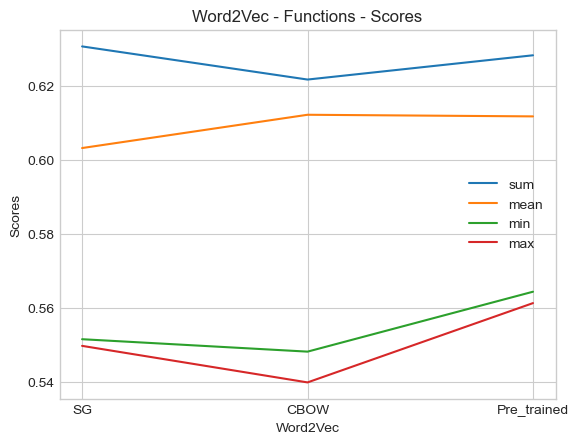

In [29]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.title('Word2Vec - Functions - Scores')
for fi in range(4):
    plt.plot(m_names, scores[fi], label=f_names[fi])
plt.xlabel('Word2Vec')
plt.ylabel('Scores')
plt.legend()
plt.show()


**(Bonus)** To have a better accuracy, we could try two things:
- Better aggregation methods (weight by tf-idf ?)
- Another word vectorizing method such as [fasttext](https://radimrehurek.com/gensim/models/fasttext.html)
- A document vectorizing method such as [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html)

#### FastText

In [30]:
# fasttext
ft = gensim.models.FastText(text)

2023-02-16 00:44:03,967 : INFO : collecting all words and their counts
2023-02-16 00:44:03,968 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-02-16 00:44:04,248 : INFO : PROGRESS: at sentence #10000, processed 2426102 words, keeping 61702 word types
2023-02-16 00:44:04,520 : INFO : PROGRESS: at sentence #20000, processed 4816878 words, keeping 84298 word types
2023-02-16 00:44:04,662 : INFO : collected 93201 word types from a corpus of 6022875 raw words and 25000 sentences
2023-02-16 00:44:04,662 : INFO : Creating a fresh vocabulary
2023-02-16 00:44:04,750 : INFO : FastText lifecycle event {'msg': 'effective_min_count=5 retains 33359 unique words (35.79253441486679%% of original 93201, drops 59842)', 'datetime': '2023-02-16T00:44:04.750266', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2023-02-16 00:44:04,750 : INFO : FastText lifecycle event

2023-02-16 00:44:49,372 : INFO : EPOCH 4 - PROGRESS: at 14.36% examples, 323838 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:44:50,374 : INFO : EPOCH 4 - PROGRESS: at 21.82% examples, 327356 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:44:51,379 : INFO : EPOCH 4 - PROGRESS: at 29.00% examples, 327287 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:44:52,389 : INFO : EPOCH 4 - PROGRESS: at 36.19% examples, 326419 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:44:53,406 : INFO : EPOCH 4 - PROGRESS: at 43.60% examples, 326073 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:44:54,411 : INFO : EPOCH 4 - PROGRESS: at 50.57% examples, 325450 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:44:55,436 : INFO : EPOCH 4 - PROGRESS: at 58.21% examples, 325877 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:44:56,440 : INFO : EPOCH 4 - PROGRESS: at 65.35% examples, 325446 words/s, in_qsize 5, out_qsize 0
2023-02-16 00:44:57,458 : INFO : EPOCH 4 - PROGRESS: at 72.83% examples, 324567 words/s, in_qsiz

In [31]:
print("great and good:",ft.wv.similarity("great","good"))
print("great and bad:",ft.wv.similarity("great","bad"))

great and good: 0.7687962
great and bad: 0.5416878


In [34]:
for word in ['movie', 'awesome', 'actor']:
    print(word, ':')
    for item in ft.wv.most_similar(word,topn=5):
        print('\t', item)

movie :
	 ('moovie', 0.96757572889328)
	 ('film', 0.9341885447502136)
	 ('telemovie', 0.9299285411834717)
	 ('moviegoer', 0.9175208806991577)
	 ('microfilm', 0.8816311955451965)
awesome :
	 ('Awesome', 0.9397410154342651)
	 ('awsome', 0.8085961937904358)
	 ('gruesome', 0.8025217652320862)
	 ('tiresome', 0.7847380638122559)
	 ('amazing', 0.7798058986663818)
actor :
	 ('Factor', 0.920687735080719)
	 ('tractor', 0.8570579290390015)
	 ('Contractor', 0.8470588326454163)
	 ('benefactor', 0.8426493406295776)
	 ('actress', 0.8383766412734985)


In [40]:
vectorize_train_test(np.sum, ft.wv)

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.59228

In [41]:
vectorize_train_test(np.mean, ft.wv)

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.59196

#### Doc2vec

In [43]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

train_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_df.text)]
d2v = Doc2Vec(train_documents)

2023-02-16 09:48:57,615 : INFO : collecting all words and their counts
2023-02-16 09:48:57,616 : WARNING : Each 'words' should be a list of words (usually unicode strings). First 'words' here is instead plain <class 'str'>.
2023-02-16 09:48:57,616 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2023-02-16 09:48:58,550 : INFO : PROGRESS: at example #10000, processed 13421008 words (14388678/s), 163 word types, 0 tags
2023-02-16 09:48:59,458 : INFO : PROGRESS: at example #20000, processed 26524225 words (14423886/s), 174 word types, 0 tags
2023-02-16 09:48:59,918 : INFO : collected 178 word types and 25000 unique tags from a corpus of 25000 examples and 33126715 words
2023-02-16 09:48:59,918 : INFO : Creating a fresh vocabulary
2023-02-16 09:48:59,919 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 147 unique words (82.58426966292134%% of original 178, drops 31)', 'datetime': '2023-02-16T09:48:59.919687', 'gensim': '4.1.2', 'python'

2023-02-16 09:49:32,463 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-02-16 09:49:32,463 : INFO : EPOCH - 6 : training on 33126715 raw words (7228642 effective words) took 5.4s, 1339671 effective words/s
2023-02-16 09:49:33,467 : INFO : EPOCH 7 - PROGRESS: at 17.88% examples, 1307155 words/s, in_qsize 5, out_qsize 0
2023-02-16 09:49:34,467 : INFO : EPOCH 7 - PROGRESS: at 35.92% examples, 1314184 words/s, in_qsize 5, out_qsize 0
2023-02-16 09:49:35,468 : INFO : EPOCH 7 - PROGRESS: at 54.29% examples, 1323443 words/s, in_qsize 5, out_qsize 0
2023-02-16 09:49:36,469 : INFO : EPOCH 7 - PROGRESS: at 73.43% examples, 1329329 words/s, in_qsize 6, out_qsize 0
2023-02-16 09:49:37,470 : INFO : EPOCH 7 - PROGRESS: at 92.04% examples, 1331951 words/s, in_qsize 6, out_qsize 0
2023-02-16 09:49:37,885 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-02-16 09:49:37,885 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-02-16 09:49:3

In [45]:
train_text = train_df.text.map(preprocess)
test_text = test_df.text.map(preprocess)

y = np.array(train_df.label)
y_test = np.array(test_df.label)

X = [d2v.infer_vector(t.split()) for t in train_text]
X_test = [d2v.infer_vector(t.split()) for t in test_text]

lr = LogisticRegression()
lr.fit(X, y)

y_pred = lr.predict(X_test)
print('Accuracy :', accuracy_score(y_pred, y_test))

Accuracy : 0.5604


/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Tf-idf

In [ ]:
train_corpus = train_df.text.map(preprocess)
test_corpus = test_df.text.map(preprocess)

In [ ]:
# tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=True)
vectors = vectorizer.fit_transform(train_corpus)
matrix = vectors.toarray()

# features trick
features = vectorizer.get_feature_names_out()
# clé : mot, valeur : index
vk_features = dict(zip(features, np.arange(0, len(features))))

In [ ]:
test_vectors = vectorizer.transform(test_df.text)
test_matrix = test_vectors.toarray()

In [ ]:
def vectorize_tfidf(document_index, 
                    f=np.mean,
                    corpus=train_df.text, 
                    matrix=matrix, 
                    vk_features=vk_features,
                    model=wv_pre_trained):
    
    doc = corpus[document_index]
    doc_matrix = matrix[document_index]
    
    vec = []
    for word in doc:
        if word.lower() in vk_features and word in model.key_to_index:
            tf_idf_score = doc_matrix[ vk_features[word.lower()] ]
            w2v_matrix = np.array(model[word])
            vec.append( list( tf_idf_score * w2v_matrix ) )
            
    print(vec)
    return f(vec, axis=0)

In [ ]:
X = [vectorize_tfidf(i) for i in range(len(train_corpus))]
y = np.array(train_df.label)

lr = LogisticRegression()
lr.fit(X, y)

In [ ]:
X_test = [vectorize_tfidf(i, corpus=test_corpus, matrix=test_matrix) for i in range(len(test_corpus))]
y_test = np.array(test_df.label)

y_pred = lr.predict(X_test)
accuracy_score(y_pred, y_test)